In [5]:
from xml.etree import ElementTree as ET
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import requests
import concurrent

In [10]:
endpoint = 'https://storage.googleapis.com/validaciones_tmsa/'
def descargar_archivo(carpeta_destino, destino, url = endpoint):
    file = os.path.join(carpeta_destino, destino.split('/')[-1])
    response = requests.get(url+destino)
    if response.status_code == 200:
        with open(file, 'wb') as f:
            f.write(response.content)
        print(f'Archivo descargado a {file}.')
    else:
        print(f'Error al descargar el archivo: {response.status_code}')

def descargar_archivos_paralelo(carpeta_destino, lista_destinos, url = endpoint):
    print(f'Descargando {len(lista_destinos)} archivos en paralelo...')
    with concurrent.futures.ThreadPoolExecutor() as executor:
        print(f'Usando {executor._max_workers} hilos...')
        executor.map(lambda x: descargar_archivo(carpeta_destino, x, url), lista_destinos)

In [11]:
response = requests.get(endpoint)
xml_data = response.text
root = ET.fromstring(xml_data)

# Ingresos

In [12]:
dir_ingresos = "assets/ingresos"

if not os.path.exists("assets"):
    os.makedirs("assets")

if not os.path.exists(dir_ingresos):
    os.makedirs(dir_ingresos)

In [13]:
files_ingresos = []

namespace = {'ns': 'http://doc.s3.amazonaws.com/2006-03-01'}
total_size = 0
for element, size in zip(root.iterfind('.//ns:Key', namespace), root.iterfind('.//ns:Size', namespace)):
    if '2024 Intervalo 15 Mint.xlsx' in element.text:
        files_ingresos.append(element.text)
        total_size += int(size.text)

In [69]:
total_size_gb = total_size / (1024**3)
print(f'Tamaño total: {total_size_gb:.2f} GB')

Tamaño total: 0.04 GB


In [70]:
descargar_archivos_paralelo(dir_ingresos, files_ingresos)

Descargando 3 archivos en paralelo...
Usando 12 hilos...


Archivo descargado a assets/ingresos\03 TM Resumen de Validaciones Troncales al 31 Mar 2024 Intervalo 15 Mint.xlsx.
Archivo descargado a assets/ingresos\02 TM Resumen de Validaciones Troncales al 29 Feb 2024 Intervalo 15 Mint.xlsx.
Archivo descargado a assets/ingresos\01 TM Resumen de Validaciones Troncales al 31 Ene 2024 Intervalo 15 Mint.xlsx.


In [71]:
xls_files_ingresos = os.listdir(dir_ingresos)

In [72]:
df_ingresos = [pd.read_excel(f"{dir_ingresos}/{x}", skiprows=6, usecols="B:AL") for x in xls_files_ingresos]

In [73]:
for i in range(len(df_ingresos)):
    df_ingresos[i] = df_ingresos[i][df_ingresos[i]['Acceso de Estación'].str.contains('SUR U. NACIONAL', na=False)]
    df_ingresos[i] = df_ingresos[i].iloc[:, 4:-1]
    df_ingresos[i] = df_ingresos[i].groupby('Intervalo', as_index=False).sum()
    df_ingresos[i].sort_values(by=['Intervalo'], inplace=True)
    df_ingresos[i].reset_index(drop=True, inplace=True)

In [74]:
df_ingresos[2]

,Intervalo,2024-03-01 00:00:00,2024-03-02 00:00:00,2024-03-03 00:00:00,2024-03-04 00:00:00,2024-03-05 00:00:00,2024-03-06 00:00:00,2024-03-07 00:00:00,2024-03-08 00:00:00,2024-03-09 00:00:00,...,2024-03-22 00:00:00,2024-03-23 00:00:00,2024-03-24 00:00:00,2024-03-25 00:00:00,2024-03-26 00:00:00,2024-03-27 00:00:00,2024-03-28 00:00:00,2024-03-29 00:00:00,2024-03-30 00:00:00,2024-03-31 00:00:00
0,04:15:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,04:30:00,4.0,8.0,6.0,4.0,4.0,4.0,3.0,3.0,6.0,...,7.0,6.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,1.0
2,04:45:00,8.0,5.0,0.0,4.0,15.0,12.0,8.0,7.0,7.0,...,7.0,7.0,1.0,1.0,6.0,5.0,1.0,1.0,1.0,3.0
3,05:00:00,16.0,5.0,3.0,13.0,14.0,22.0,20.0,14.0,14.0,...,26.0,11.0,6.0,2.0,11.0,9.0,3.0,1.0,4.0,0.0
4,05:15:00,16.0,13.0,4.0,8.0,14.0,15.0,16.0,14.0,13.0,...,14.0,17.0,6.0,7.0,9.0,12.0,1.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,22:30:00,77.0,25.0,2.0,37.0,21.0,40.0,80.0,59.0,19.0,...,24.0,32.0,1.0,0.0,9.0,37.0,0.0,0.0,6.0,0.0
74,22:45:00,37.0,17.0,0.0,4.0,11.0,20.0,36.0,66.0,8.0,...,24.0,21.0,0.0,0.0,7.0,25.0,0.0,0.0,6.0,0.0
75,23:00:00,13.0,5.0,0.0,0.0,3.0,2.0,9.0,18.0,2.0,...,14.0,2.0,0.0,0.0,3.0,11.0,0.0,0.0,1.0,0.0
76,23:15:00,4.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,2.0,0.0


In [75]:
df_ingresos_1t_2024 = df_ingresos[0]
for df in df_ingresos[1:]:
    df_ingresos_1t_2024 = pd.merge(df_ingresos_1t_2024, df, on='Intervalo', how='outer')

In [76]:
df_ingresos_1t_2024['Intervalo'].iloc[0]

datetime.time(4, 15)

In [77]:
df_ingresos_1t_2024.fillna(0, inplace=True)
df_ingresos_1t_2024.set_index('Intervalo', inplace=True)

In [78]:
df_ingresos_1t_2024

,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-06,2024-01-07,2024-01-08,2024-01-09,2024-01-10,...,2024-03-22,2024-03-23,2024-03-24,2024-03-25,2024-03-26,2024-03-27,2024-03-28,2024-03-29,2024-03-30,2024-03-31
Intervalo,,,,,,,,,,,,,,,,,,,,,
04:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
04:30:00,2.0,4.0,3.0,3.0,3.0,2.0,2.0,5.0,4.0,2.0,...,7.0,6.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,1.0
04:45:00,1.0,1.0,9.0,4.0,3.0,4.0,0.0,2.0,4.0,4.0,...,7.0,7.0,1.0,1.0,6.0,5.0,1.0,1.0,1.0,3.0
05:00:00,0.0,9.0,7.0,8.0,11.0,5.0,2.0,1.0,6.0,12.0,...,26.0,11.0,6.0,2.0,11.0,9.0,3.0,1.0,4.0,0.0
05:15:00,1.0,12.0,17.0,12.0,14.0,12.0,1.0,7.0,15.0,8.0,...,14.0,17.0,6.0,7.0,9.0,12.0,1.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:30:00,0.0,9.0,6.0,5.0,10.0,8.0,0.0,0.0,13.0,3.0,...,24.0,32.0,1.0,0.0,9.0,37.0,0.0,0.0,6.0,0.0
22:45:00,0.0,4.0,2.0,7.0,10.0,3.0,0.0,0.0,5.0,7.0,...,24.0,21.0,0.0,0.0,7.0,25.0,0.0,0.0,6.0,0.0
23:00:00,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,3.0,...,14.0,2.0,0.0,0.0,3.0,11.0,0.0,0.0,1.0,0.0


In [79]:
df_ingresos_1t_2024['2024-03-01 00:00:00'] = df_ingresos_1t_2024['2024-03-01 00:00:00_x'] + df_ingresos_1t_2024['2024-03-01 00:00:00_y']
df_ingresos_1t_2024['2024-03-02 00:00:00'] = df_ingresos_1t_2024['2024-03-02 00:00:00_x'] + df_ingresos_1t_2024['2024-03-02 00:00:00_y']
df_ingresos_1t_2024.drop(columns=['2024-03-01 00:00:00_x', '2024-03-01 00:00:00_y', '2024-03-02 00:00:00_x', '2024-03-02 00:00:00_y'], inplace=True)

In [80]:
df_ingresos_1t_2024.columns = pd.to_datetime(df_ingresos_1t_2024.columns).date
df_ingresos_1t_2024.sort_index(axis=1, inplace=True)

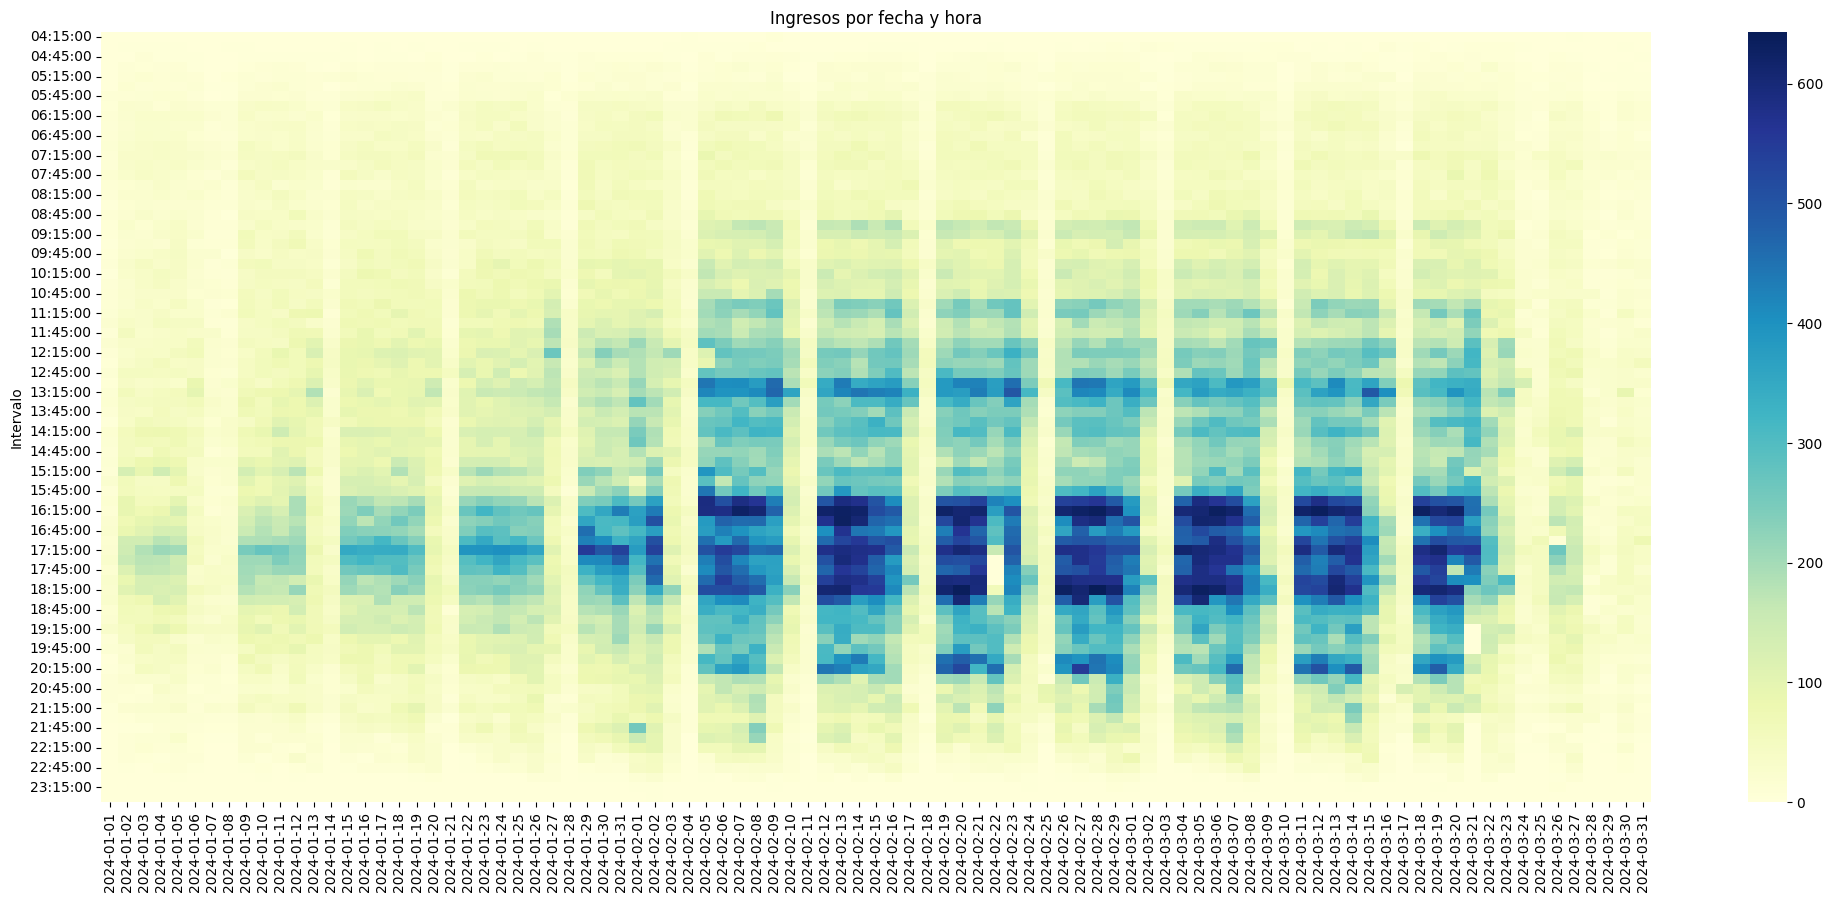

In [81]:
plt.figure(figsize=(25, 10))
sns.heatmap(df_ingresos_1t_2024, cmap='YlGnBu')
plt.title('Ingresos por fecha y hora')
plt.show()

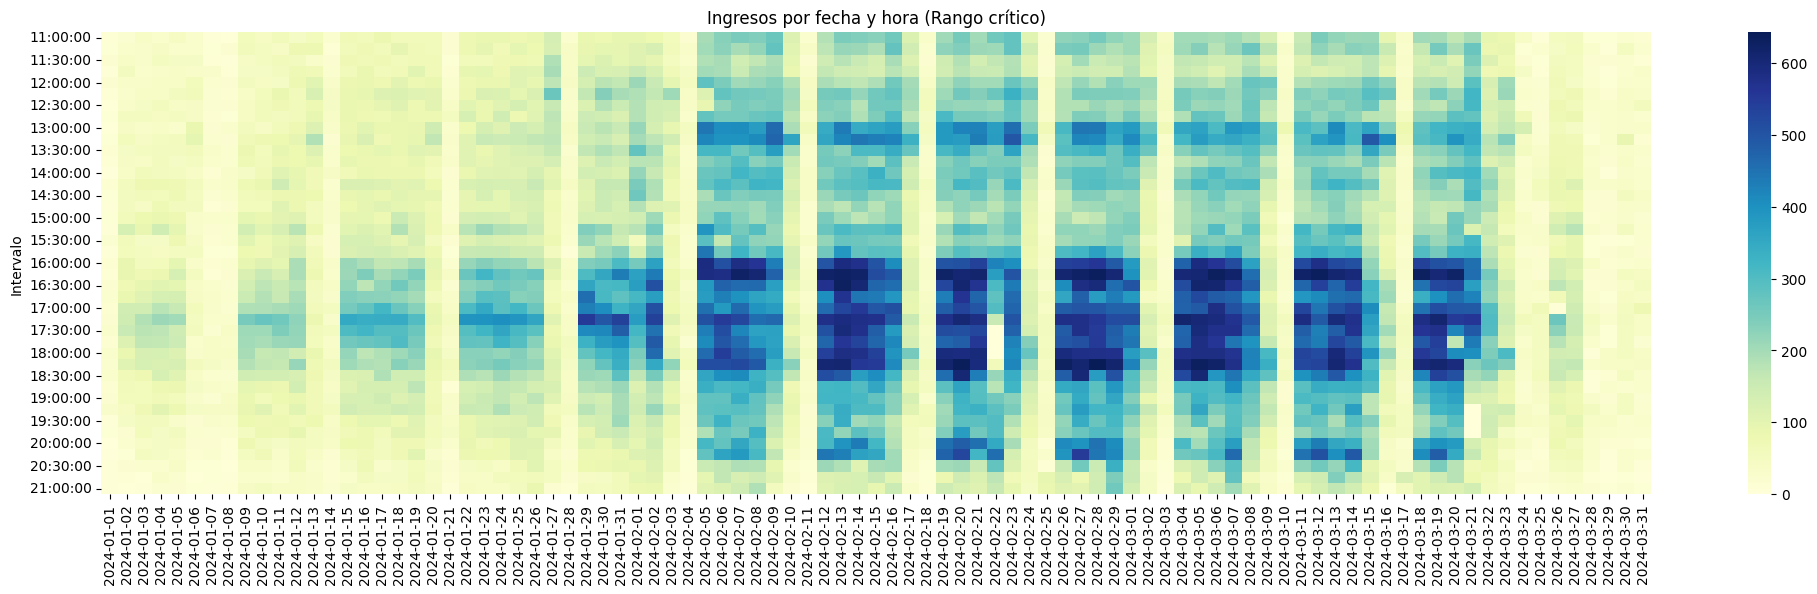

In [82]:
# Supongamos que los rangos críticos son entre las 10:00 y las 14:00
start_time = datetime.time(11, 0)
end_time = datetime.time(21, 0)

# Filtra el DataFrame para incluir solo las horas entre start_time y end_time
df_filtered = df_ingresos_1t_2024.loc[(df_ingresos_1t_2024.index >= start_time) & (df_ingresos_1t_2024.index <= end_time)]

# Ahora puedes visualizar solo este rango de tiempo
plt.figure(figsize=(25, 6))
sns.heatmap(df_filtered, cmap='YlGnBu')
plt.title('Ingresos por fecha y hora (Rango crítico)')
plt.show()


In [83]:
df_ingresos_1t_2024_T = df_ingresos_1t_2024.T
df_ingresos_1t_2024_T = df_ingresos_1t_2024_T.reset_index()
df_ingresos_1t_2024_T['dia'] = pd.to_datetime(df_ingresos_1t_2024_T['index']).dt.weekday#day_name()
df_ingresos_1t_2024_T.set_index('index', inplace=True)
df_ingresos_by_day = df_ingresos_1t_2024_T.groupby('dia').mean().T

In [84]:
df_ingresos_by_day.T

Intervalo,04:15:00,04:30:00,04:45:00,05:00:00,05:15:00,05:30:00,05:45:00,06:00:00,06:15:00,06:30:00,...,21:15:00,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00
dia,,,,,,,,,,,,,,,,,,,,,
0,0.230769,2.923077,5.307692,10.153846,13.846154,14.461538,24.076923,34.153846,37.538462,36.923077,...,77.538462,56.692308,64.538462,60.846154,32.692308,15.615385,6.230769,1.769231,0.692308,0.000000
1,0.076923,2.846154,6.615385,12.461538,16.307692,19.615385,25.384615,43.461538,48.153846,42.923077,...,86.692308,59.692308,68.615385,56.384615,34.307692,18.846154,11.230769,2.846154,1.000000,0.076923
2,0.230769,2.230769,7.153846,14.615385,14.076923,17.846154,24.538462,44.076923,48.153846,45.461538,...,95.538462,58.615385,72.692308,58.615385,44.692308,27.769231,14.384615,5.076923,0.769231,0.076923
3,0.230769,3.384615,6.615385,13.230769,13.846154,19.153846,24.076923,40.384615,45.076923,44.000000,...,127.230769,81.000000,102.846154,80.923077,46.076923,29.153846,20.384615,6.538462,1.153846,0.000000
4,0.923077,2.769231,6.230769,14.153846,14.076923,15.923077,25.307692,34.923077,42.153846,39.230769,...,84.307692,58.923077,59.769231,54.615385,44.307692,37.230769,26.923077,10.692308,1.615385,0.692308
5,0.538462,3.846154,5.153846,8.615385,10.923077,12.846154,15.615385,22.230769,29.307692,26.384615,...,39.846154,28.846154,22.846154,20.615385,21.307692,17.076923,12.692308,3.769231,0.692308,0.230769
6,0.615385,2.461538,2.538462,2.615385,5.153846,5.769231,10.153846,15.307692,15.384615,14.769231,...,20.307692,10.230769,10.230769,4.076923,1.692308,0.384615,0.000000,0.076923,0.000000,0.000000


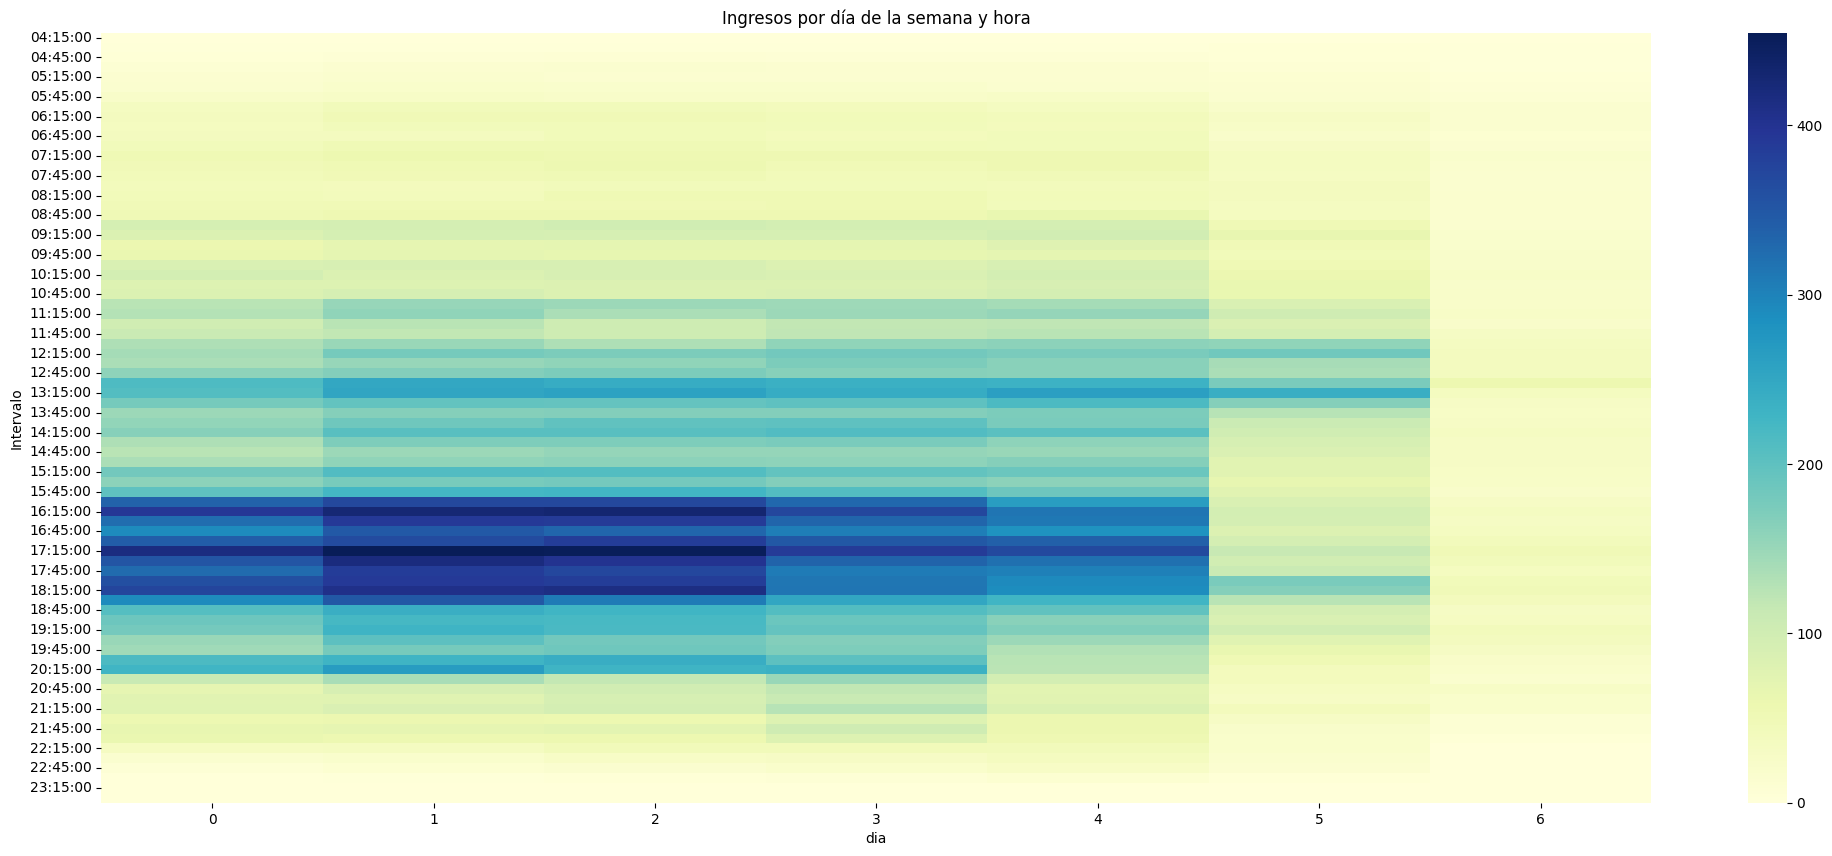

In [85]:
plt.figure(figsize=(25, 10))
sns.heatmap(df_ingresos_by_day, cmap='YlGnBu')
plt.title('Ingresos por día de la semana y hora')
plt.show()

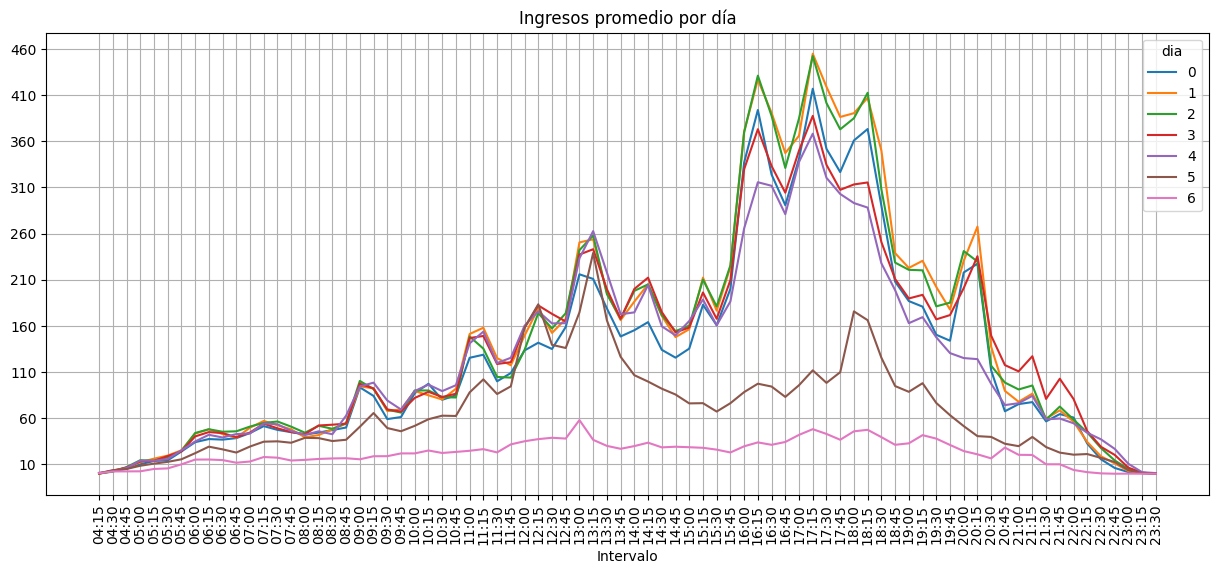

In [86]:
df_ingresos_by_day.plot(kind='line', figsize=(15, 6))
plt.title('Ingresos promedio por día')
plt.xticks(df_ingresos_by_day.index.to_list(), rotation=90)
ymin, ymax = plt.ylim()
y_ticks = np.linspace(10, 460, num=10)
plt.yticks(y_ticks)
plt.grid()
plt.show()


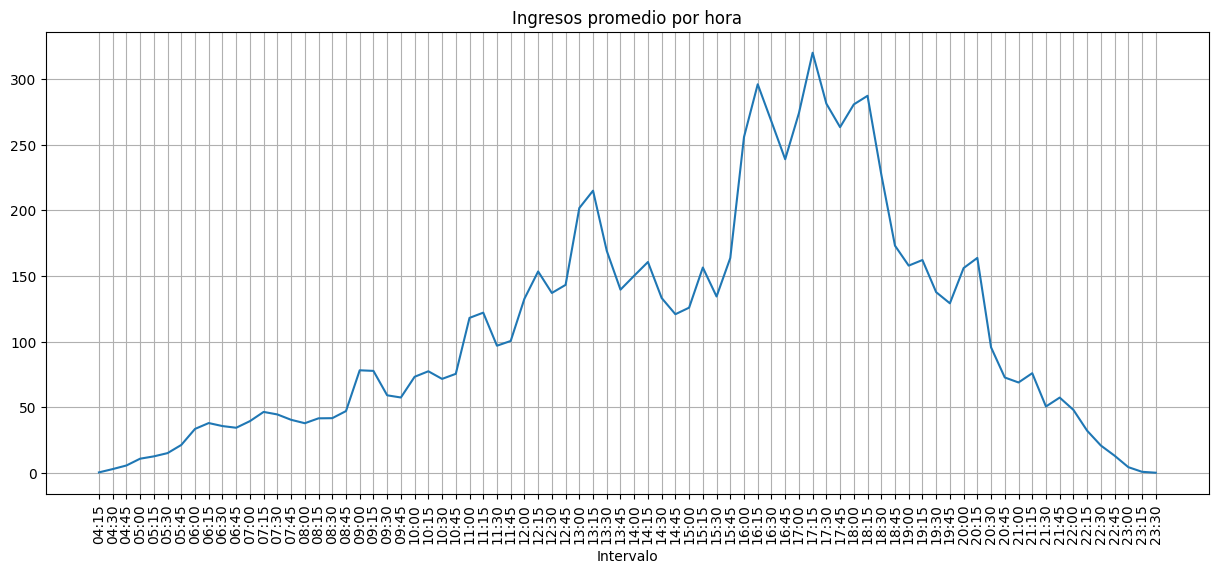

In [87]:
df_ingresos_promedio = df_ingresos_1t_2024.mean(axis=1)

df_ingresos_promedio.plot(kind='line', figsize=(15, 6))
plt.title('Ingresos promedio por hora')
plt.xticks(df_ingresos_promedio.index.to_list(), rotation=90)
plt.grid()
plt.show()

In [88]:
df_ingresos_promedio.loc[datetime.time(16,0,0):datetime.time(18,30,0)]

Intervalo
16:00:00    255.791209
16:15:00    295.923077
16:30:00    267.538462
16:45:00    238.846154
17:00:00    273.912088
17:15:00    319.945055
17:30:00    281.186813
17:45:00    263.263736
18:00:00    280.593407
18:15:00    287.142857
18:30:00    227.406593
dtype: float64

# Salidas

In [4]:
dir_salidas = "assets/salidas"

if not os.path.exists("assets"):
    os.makedirs("assets")

if not os.path.exists(dir_salidas):
    os.makedirs(dir_salidas)

In [15]:
files_salidas = []

namespace = {'ns': 'http://doc.s3.amazonaws.com/2006-03-01'}
total_size = 0
for element, size in zip(root.iterfind('.//ns:Key', namespace), root.iterfind('.//ns:Size', namespace)):
    if 'Salidas/2024' in element.text:
        if 'Enero' in element.text or 'Febrero' in element.text or 'Marzo' in element.text:
            files_salidas.append(element.text)
            total_size += int(size.text)

In [16]:
files_salidas

['Salidas/2024/Resumen_Salidas_Cada_15_minutos_Enero_2024.xlsx',
 'Salidas/2024/Resumen_Salidas_Cada_15_minutos_Febrero_2024.xlsx',
 'Salidas/2024/Resumen_Salidas_Cada_15_minutos_Marzo_2024.xlsx']

In [17]:
descargar_archivos_paralelo(dir_salidas, files_salidas)

Descargando 3 archivos en paralelo...
Usando 12 hilos...
Archivo descargado a assets/salidas\Resumen_Salidas_Cada_15_minutos_Marzo_2024.xlsx.
Archivo descargado a assets/salidas\Resumen_Salidas_Cada_15_minutos_Febrero_2024.xlsx.
Archivo descargado a assets/salidas\Resumen_Salidas_Cada_15_minutos_Enero_2024.xlsx.


In [24]:
xls_files_salidas = os.listdir(dir_salidas)

In [26]:
df_salidas = [pd.read_excel(f"{dir_salidas}/{x}", skiprows=6) for x in xls_files_salidas]

In [35]:
for i in range(len(df_salidas)):
    df_salidas[i] = df_salidas[i][df_salidas[i]['Acceso de Estación'].str.contains('SUR U. NACIONAL', na=False)].iloc[:, 3:-1]
    df_salidas[i] = df_salidas[i].groupby('INTERVALO', as_index=False).sum()
    df_salidas[i].sort_values(by=['INTERVALO'], inplace=True)
    df_salidas[i].reset_index(drop=True, inplace=True)

In [46]:
df_salidas_1t_2024 = df_salidas[0]
for df in df_salidas[1:]:
    df_salidas_1t_2024 = pd.merge(df_salidas_1t_2024, df, on='INTERVALO', how='outer')

In [47]:
df_salidas_1t_2024.fillna(0, inplace=True)
df_salidas_1t_2024.set_index('INTERVALO', inplace=True)

In [48]:
df_salidas_1t_2024.columns

Index([    2024-01-01 00:00:00,     2024-01-02 00:00:00,
           2024-01-03 00:00:00,     2024-01-04 00:00:00,
           2024-01-05 00:00:00,     2024-01-06 00:00:00,
           2024-01-07 00:00:00,     2024-01-08 00:00:00,
           2024-01-09 00:00:00,     2024-01-10 00:00:00,
           2024-01-11 00:00:00,     2024-01-12 00:00:00,
           2024-01-13 00:00:00,     2024-01-14 00:00:00,
           2024-01-15 00:00:00,     2024-01-16 00:00:00,
           2024-01-17 00:00:00,     2024-01-18 00:00:00,
           2024-01-19 00:00:00,     2024-01-20 00:00:00,
           2024-01-21 00:00:00,     2024-01-22 00:00:00,
           2024-01-23 00:00:00,     2024-01-24 00:00:00,
           2024-01-25 00:00:00,     2024-01-26 00:00:00,
           2024-01-27 00:00:00,     2024-01-28 00:00:00,
           2024-01-29 00:00:00,     2024-01-30 00:00:00,
           2024-01-31 00:00:00,     2024-02-01 00:00:00,
           2024-02-02 00:00:00,     2024-02-03 00:00:00,
           2024-02-04 00:00:00,

In [49]:
df_salidas_1t_2024['2024-03-01 00:00:00'] = df_salidas_1t_2024['2024-03-01 00:00:00_x'] + df_salidas_1t_2024['2024-03-01 00:00:00_y']
df_salidas_1t_2024['2024-03-02 00:00:00'] = df_salidas_1t_2024['2024-03-02 00:00:00_x'] + df_salidas_1t_2024['2024-03-02 00:00:00_y']
df_salidas_1t_2024.drop(columns=['2024-03-01 00:00:00_x', '2024-03-01 00:00:00_y', '2024-03-02 00:00:00_x', '2024-03-02 00:00:00_y'], inplace=True)

In [50]:
df_salidas_1t_2024.columns = pd.to_datetime(df_salidas_1t_2024.columns).date
df_salidas_1t_2024.sort_index(axis=1, inplace=True)

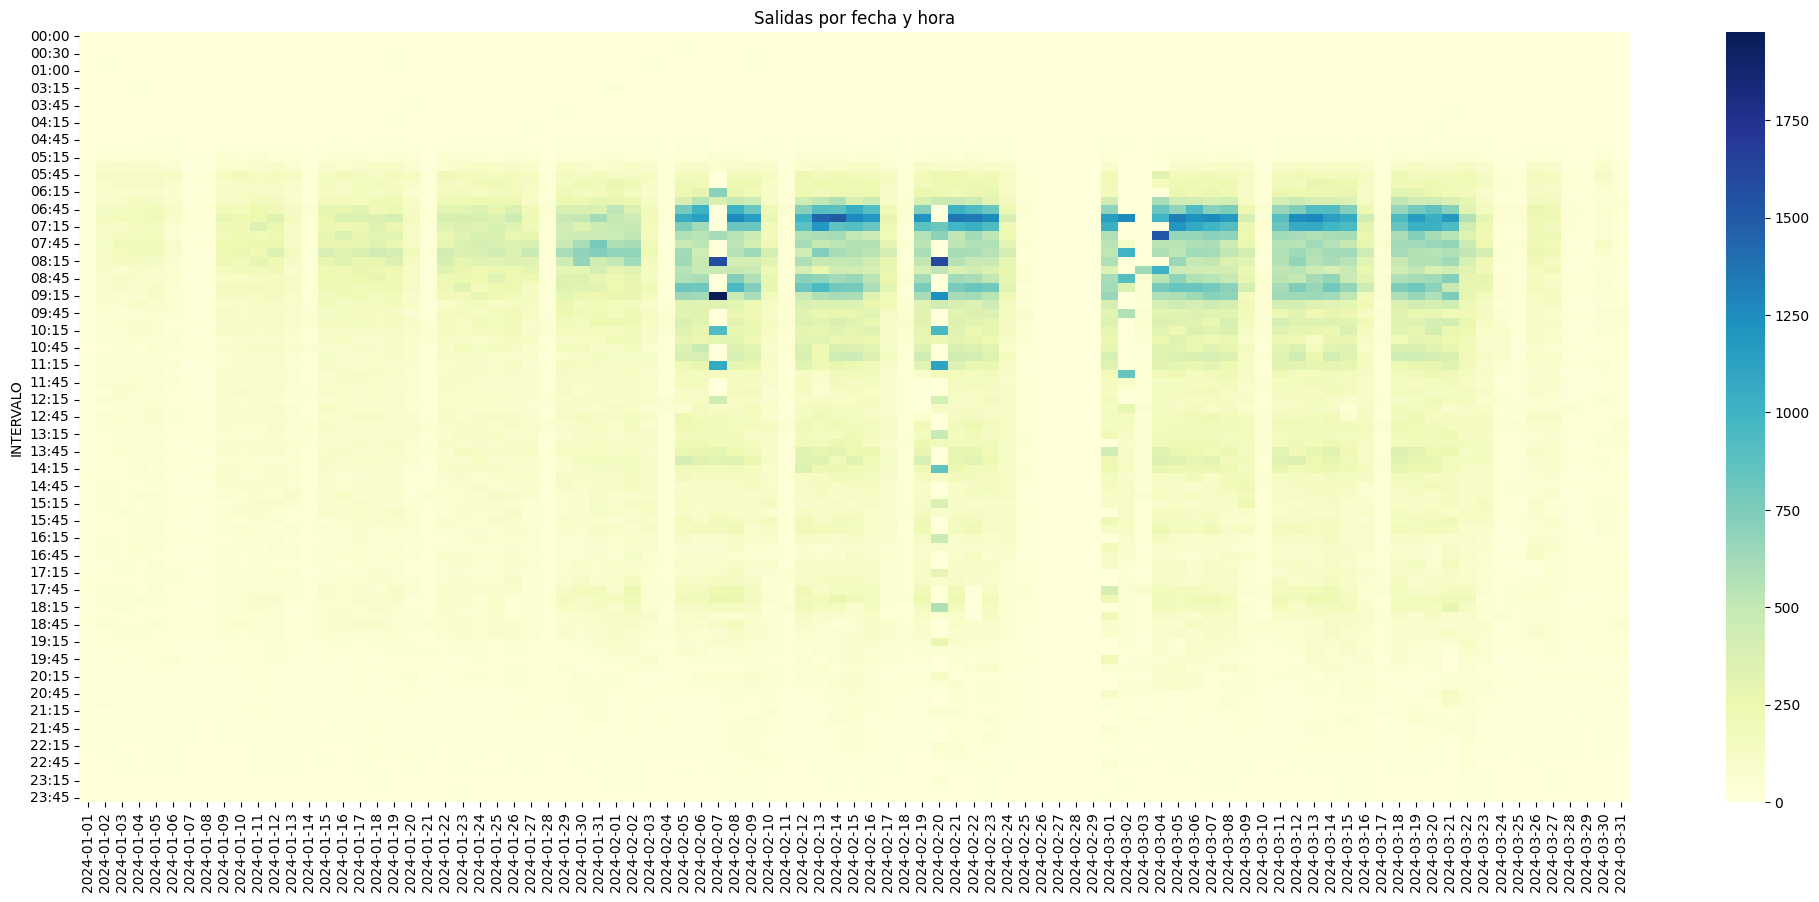

In [51]:
plt.figure(figsize=(25, 10))
sns.heatmap(df_salidas_1t_2024, cmap='YlGnBu')
plt.title('Salidas por fecha y hora')
plt.show()

In [53]:
df_salidas_1t_2024_T = df_salidas_1t_2024.T
df_salidas_1t_2024_T.reset_index(inplace=True)
df_salidas_1t_2024_T['dia'] = pd.to_datetime(df_salidas_1t_2024_T['index']).dt.weekday#day_name()
df_salidas_1t_2024_T.set_index('index', inplace=True)
df_salidas_by_day = df_salidas_1t_2024_T.groupby('dia').mean().T

In [56]:
df_salidas_by_day

dia,0,1,2,3,4,5,6
INTERVALO,,,,,,,
00:00,0.230769,2.153846,1.230769,0.923077,1.538462,0.923077,1.615385
00:15,1.230769,0.692308,1.000000,0.923077,1.076923,0.307692,0.384615
00:30,0.230769,0.769231,1.307692,0.230769,4.000000,0.692308,1.230769
00:45,0.769231,1.230769,1.000000,0.769231,2.384615,2.384615,0.384615
01:00,0.461538,0.000000,0.153846,0.000000,0.000000,0.000000,0.076923
...,...,...,...,...,...,...,...
22:45,4.615385,7.153846,9.846154,8.846154,22.076923,13.846154,3.076923
23:00,4.692308,6.153846,8.538462,10.230769,15.615385,11.923077,1.461538
23:15,2.384615,7.153846,5.000000,6.076923,9.769231,8.153846,1.769231


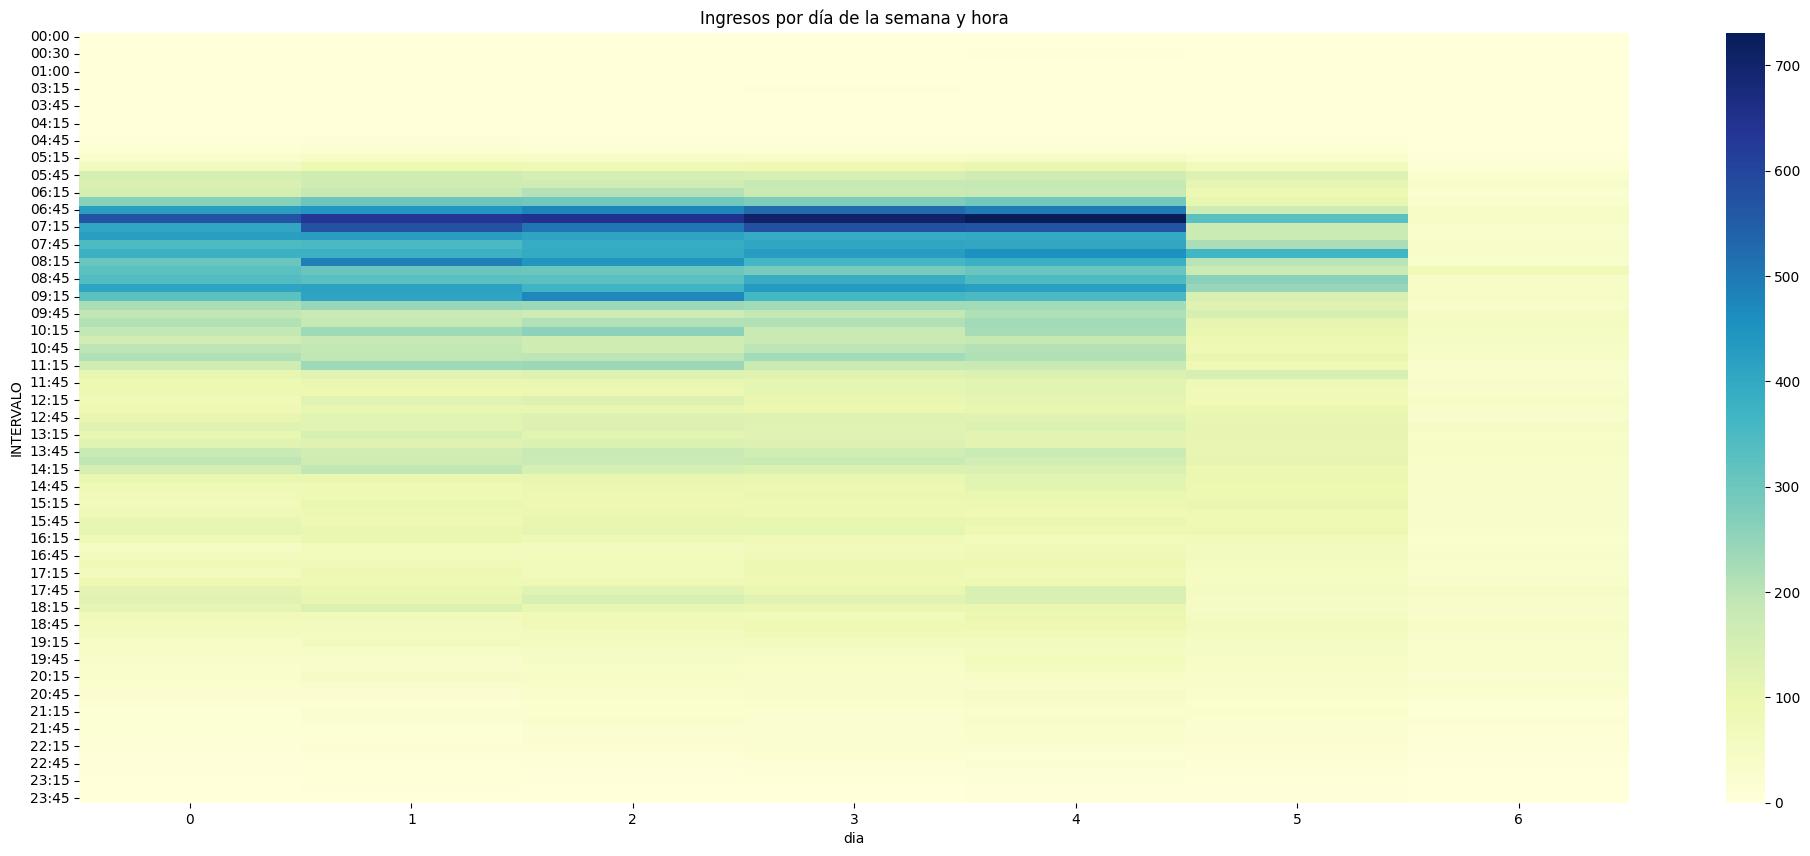

In [57]:
plt.figure(figsize=(25, 10))
sns.heatmap(df_salidas_by_day, cmap='YlGnBu')
plt.title('Ingresos por día de la semana y hora')
plt.show()

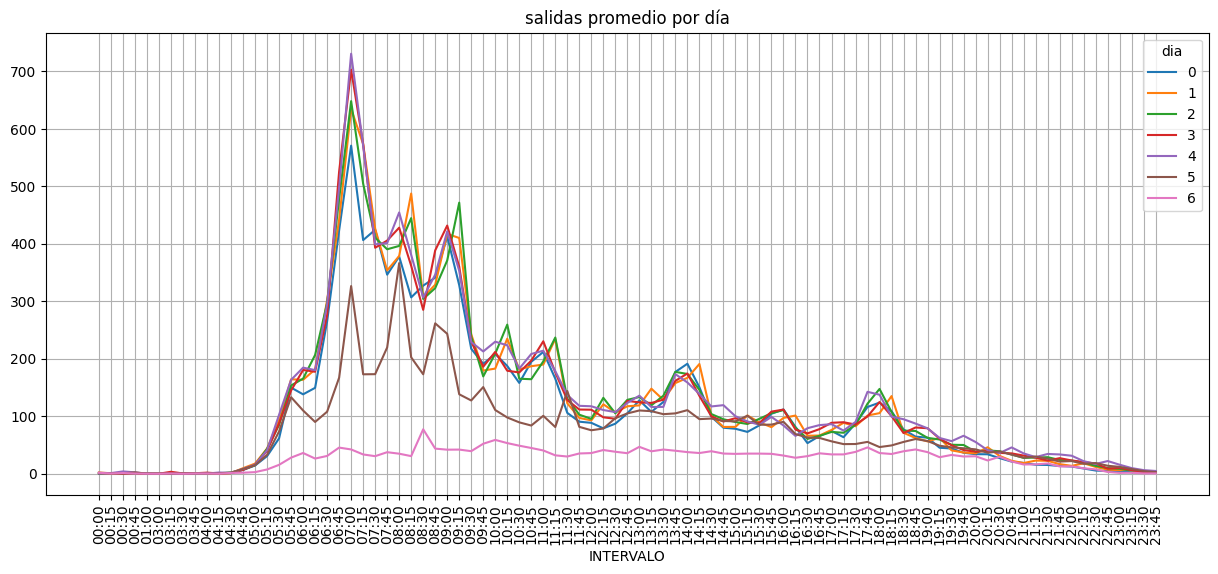

In [89]:
df_salidas_by_day.plot(kind='line', figsize=(15, 6))
plt.title('salidas promedio por día')
plt.xticks(ticks=range(len(df_salidas_by_day.index)), labels=df_salidas_by_day.index, rotation=90)
plt.grid()
plt.show()

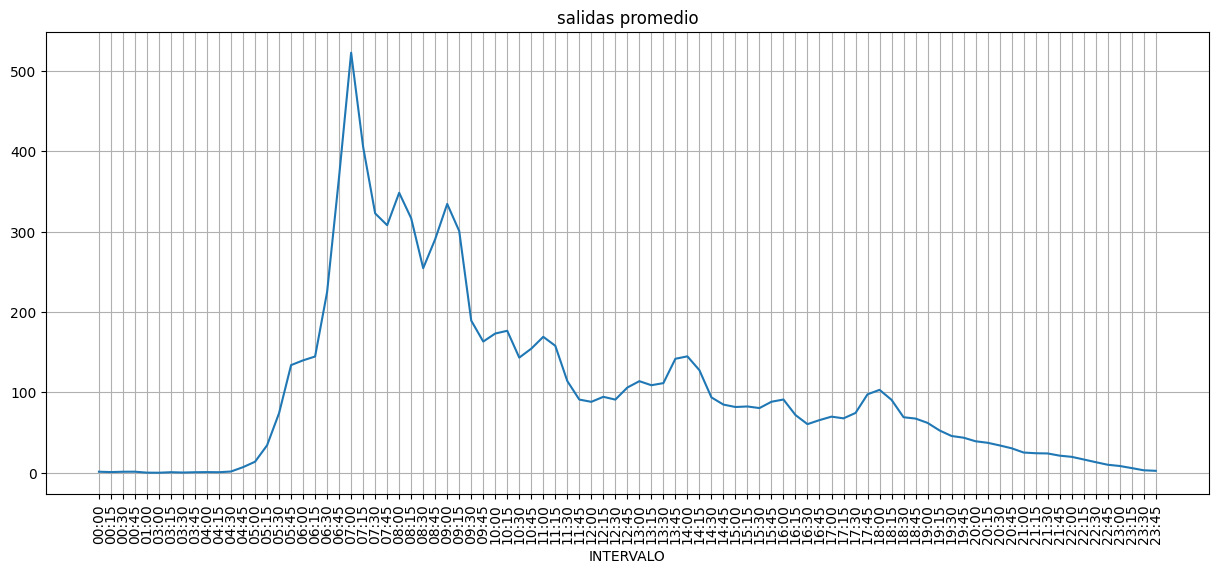

In [94]:
df_salidas_promedio = df_salidas_1t_2024.mean(axis=1)

df_salidas_promedio.plot(kind='line', figsize=(15, 6))
plt.title('salidas promedio')
plt.xticks(ticks=range(len(df_salidas_promedio.index)), labels=df_salidas_promedio.index, rotation=90)
plt.grid()
plt.show()

In [93]:
df_salidas_promedio.loc['16:00':'18:30']

INTERVALO
16:00     91.054945
16:15     71.736264
16:30     60.406593
16:45     65.428571
17:00     69.747253
17:15     67.615385
17:30     74.340659
17:45     97.516484
18:00    103.054945
18:15     90.626374
18:30     69.010989
dtype: float64